In [21]:
!pip install lmfit

In [22]:
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import lmfit
import datetime
from datetime import date
from sklearn import linear_model
import datetime
import argparse
pd.options.mode.chained_assignment = None  # default='warn'

#---------------Please adjust variables here or in the command line------------------------------------------------------------
data_path='C:\\Users\\Bringer\\Documents\\JADS\\Aa-en-Maas\\Features\\' #(--data_path)
weir='211B_211C' #(--weir)
risk_date='2021-04-01' # (--risk_date)
prediction=False # True for prediction (--prediction)
last_days=7 # (--last_days) For prediction: Defines how many days the linear model takes into account to predict the next 21 days
avg_temp=22 # (--avg_temp) For prediction: Average Temperature adjusts the prediction +/- 20%
#---------------End of adjust variables-------------------------------------------------------------------------------------------

# From now on PLEASE DO NOT CHANGE------------------------------------------------------------------------------------------------

def get_data(weir,data_path,date_format=False):
    ''' Get the feature data of the individual weir
    Keyword arguments:
    weir -- the weir name as string
    date_format -- date_format boolean 
    data_path -- the local path of the weir feature data csv's
    Returns: data as dataframe'''
    datapath=data_path+weir+'_feature_table.csv'
    data=pd.read_csv(datapath,index_col="TIME",parse_dates=True)
    if date_format:
        data.index=data.index.strftime('%Y-%m-%d')
    return data
    
def get_model(weir:str,year:int,data_path):
    '''Get the model Aa-en-Maas uses to define the backwater caused in winter
    Keyword arguments:
    weir -- the weir name as string
    year -- year as int
    data_path -- the local path of the weir feature data csv's
    Returns: model'''
    weir_data=get_data(weir,data_path,date_format=True)
    selected_data=weir_data[['VERSCHIL', 'Q']]
    # Set values of Verschil lower than 0 to 0 as backwater cannot be negative
    selected_data['VERSCHIL']=negative_backwater_to_zero(selected_data['VERSCHIL'])
    # Set the Q value also to 0 where backwater is now 0
    selected_data.loc[(selected_data.VERSCHIL == 0),'Q']=0
    # Winter season where plants are "not" growing from 1st October to end of February
    winter_data=selected_data.loc[str(year-1)+'-10-01':str(year)+'-02-31']
    # The polynomial function Aa-en-Maas currently uses
    def eqn_poly(x, a, b):
        ''' simple polynomial function'''
        return  a*(x**b)     
    mod = lmfit.Model(eqn_poly)
    lm_result = mod.fit(np.array(winter_data['VERSCHIL']), x=np.array(winter_data['Q']), a=1.0, b=1.0)
    return lm_result
    
def negative_backwater_to_zero(vegetation_data):
    '''Set values lower than 0 to 0 as backwater cannot be negative'''
    return np.clip(vegetation_data, 0, None)
    
def calc_vegetation(weir,weir_data,risk_date,data_path):
    '''Calculate the back water caused by plants of a single data point
    Keyword arguments:
    weir -- the weir name as string
    weir_data -- the feature data of the weir
    risk_date -- the date where the vegetation risk should be evaluated on
    data_path -- the local path of the weir feature data csv's
    Returns: current vegetation '''
    try:
        # Take the necessary features(VERSCHIL and Q) of the data at the given date
        risk_date_data=weir_data[['VERSCHIL', 'Q']].loc[risk_date]
    except:
        print('This date is not in the database')
    risk_date=datetime.datetime.strptime(risk_date, "%Y-%m-%d")
    current_year=risk_date.year
    try:
        #Get the winter baseline model of the current year
        model=get_model(weir,year=current_year,data_path=data_path)
    except:
        print('Error, model cannot be created for year {}'.format(current_year))
        return 0
    # If the date is in the winter period, 
    if ((risk_date.month <= 2) | (risk_date.month >= 10)):
        # the back water is assumed to be 0 as the plants do "not" grow in winter
        current_vegetation = 0
    elif (risk_date_data.empty):
        print("No flow data for "+ weir+ " on date ", risk_date)
        current_vegetation = None
    elif (len(risk_date_data) == 0):
        print("No data for ", weir, " on date ", risk_date)
        current_vegetation = None
    else:
        # Predict the vegetation for every summer data point based on the winter baseline
        winter_pred = model.eval(x=risk_date_data['Q'])
        winter_pred=negative_backwater_to_zero(winter_pred)
        # Calculate the vegetation by plants: Current back water - predicted back water based on winter
        current_vegetation= risk_date_data.loc["VERSCHIL"] - winter_pred
        current_vegetation=negative_backwater_to_zero(current_vegetation)
    return current_vegetation   
    
def calc_vegetation_risk(weir,risk_date, data_path):
    ''' Calculate the vegetation risk between 1 and 4
    Keyword arguments:
    weir -- the weir name as string
    risk_date -- the date where the vegetation risk should be evaluated on
    data_path -- the local path of the weir feature data csv's
    Returns: Risk category, Quantiles of vegetation 25,50,75'''
    weir_data=get_data(weir,date_format=True,data_path=data_path)
    # Calculate the back water by plants on given date
    current_vegetation=calc_vegetation(weir,weir_data,risk_date,data_path)
    risk_date=datetime.datetime.strptime(risk_date, "%Y-%m-%d")
    current_year=risk_date.year
    min_year=current_year - 3
    total_vegetation=[]
    # Get the vegetation for the last three years
    for year in range(min_year,current_year):
        try: 
            # load model of given year
            model_year =get_model(weir, year=year,data_path=data_path)
        except:
            print('Error,year '+str(year)+' model cannot be created')  
            continue
        # Select summer season data from March till end of September
        summer_data = weir_data.loc[str(year)+'-03-01':str(year)+'-09-31']
        # Predict the vegetation for every summer data point based on the winter baseline
        winter_pred = model_year.eval(x=summer_data['Q']) 
        winter_pred=negative_backwater_to_zero(winter_pred)
        # Calculate the vegetation by plants: Current back water - predicted back water based on winter
        vegetation_year=summer_data.loc[:,"VERSCHIL"]-winter_pred
        vegetation_year=negative_backwater_to_zero(vegetation_year)
        total_vegetation.append(vegetation_year)
    total_vegetation = pd.concat(total_vegetation)
    # Get Quantiles of the total vegetation
    vegetation_q25=np.quantile(total_vegetation,0.25)
    vegetation_q50=np.quantile(total_vegetation,0.50)
    vegetation_q75=np.quantile(total_vegetation,0.75)
    # Get Risk category based on quantile segment
    risk_cat=np.where(current_vegetation > vegetation_q75,4,np.where(current_vegetation > vegetation_q50,3,np.where(current_vegetation > vegetation_q25,2,1))).tolist()
    # Return risk category and the quantiles
    print("The risk category for the date: {} is {}. The following quantiles were used for the risk calculation 0.25:{}, 0.5:{}, 0.75:{}".format(risk_date,risk_cat,vegetation_q25, vegetation_q50, vegetation_q75))
    return [risk_cat,vegetation_q25, vegetation_q50, vegetation_q75]
    
def predict_vegetation(weir,last_days,avg_temp,data_path):
    '''Predict the vegetation of the next 21 days based on the last 7 days with linear model
    Keyword arguments:
    weir -- the weir name as string
    last_days -- the number of days the linear model should base the prediction on
    avg_temp -- the average temperature adjusting the predictions by +/- 20%
    data_path -- the local path of the weir feature data csv's
    Returns: Dataframe of the backwater predictions of the next 21 days'''
    data=get_data(weir,data_path,date_format=True)
    data.reset_index(inplace=True)
    # Get the last data points depending on number of last_days
    last_data=data.tail(last_days)
    # Get last day to calculate 
    last_day = datetime.datetime.strptime(last_data.iloc[-1]['index'], "%Y-%m-%d")
    # Get dates of the next 21 days
    new_dates=[last_day+datetime.timedelta(days=i) for i in range(1,22)]
    # Calculate back water by vegetation for the last days
    last_data['vegetation']=last_data['index'].apply(lambda row:calc_vegetation(weir,get_data(weir,data_path,date_format=True),row,data_path))
    last_data.reset_index(inplace=True)
    # Define linear model
    reg = linear_model.LinearRegression()
    # Take index and the back water by vegetation as training data
    x_train=last_data.index.to_numpy().reshape(-1, 1)
    y_train=last_data['vegetation'].to_numpy().reshape(-1, 1)
    # Fit the linear model on the last days
    reg.fit(x_train,y_train)
    # Get index for the next 21 days
    x_test=[x_train[-1]+i for i in range(1,22)]
    # Predict the vegetation for the next 21 days
    predictions=reg.predict(x_test)
    # Format
    predictions= [item for elem in predictions.tolist() for item in elem]
    # Depending on the temperature add multplication value to adjust values
    try:
        if (avg_temp > 25):
            predictions=[pred*1.2 for pred in predictions]
        elif (avg_temp<20):
            predictions=[pred*0.8 for pred in predictions]
    except:
        print("The Temperature was not available")
    data = {'index':  new_dates,'Predicted backwater by vegetation': predictions}
    df = pd.DataFrame (data, columns = ['index','Predicted backwater by vegetation'])
    print(df)
    return df
    
def main():
    parser = argparse.ArgumentParser(description='Arguments get parsed via --commands')
    parser.add_argument('--weir', type=str,default=weir)
    parser.add_argument('--risk_date', type=str, default=risk_date)
    parser.add_argument('--data_path', type=str,default=data_path)
    parser.add_argument('--prediction', type=bool,default=prediction)
    parser.add_argument('--last_days', type=int,default=last_days)
    parser.add_argument('--avg_temp', type=int,default=avg_temp)
    args = parser.parse_args([])
    if args.prediction:
        predict_vegetation(weir=args.weir,last_days=args.last_days,avg_temp=args.avg_temp,data_path=args.data_path)
    else:
        calc_vegetation_risk(weir=args.weir,risk_date=args.risk_date, data_path=args.data_path)
    
#if __name__ == '__main__':
#    main()

In [24]:
data_path='C:\\Users\\20193727\\Downloads\\data_for_students\\data\\feature_tables\\' #(--data_path)
weir='211N_211M' #(--weir)
risk_date='2021-04-28' # (--risk_date)
prediction=True # True for prediction (--prediction)
last_days=7 # (--last_days) For prediction: Defines how many days the linear model takes into account to predict the next 21 days
avg_temp=22 # (--avg_temp) For prediction: Average Temperature adjusts the prediction +/- 20%

In [25]:
from os import walk

#mypath= 'C:/Users/20193723/Documents/Data Challenge 3/Data/Individual weirs/'

def CreateYearlyCSVs(path_in:str, path_out:str, weirlist):
    """
    Iterates through the input weir csv's (path_in), makes a list of the years contained in these weirs and separates the individual years, 
    which will then be uploaded as csv's to a new folder(path_out).
    """
    for weir in weirlist: #iterate through all weirs. Weirs are in the format: '104B_104OYE_feature_table.csv'
        datapath = path_in+weir
        current = pd.read_csv(datapath,parse_dates=True) #save the current weir as a dataframe
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
        current['year'] = 'non' #create new empty year column
        for day in range(len(current)): 
            current['year'][day] = current['TIME'][day].year #for every row in the year column set value = the current year
        years = list(current['year'].unique()) #make a list of the unique years in the year column
        #print(years) #could print the years for every file
        for year in years: #for every year in the years list: create a new csv file, containing only the data from that year collected at the current weir
            df = current[current['year'] == year] 
            df.reset_index(drop= True, inplace= True)
            df.to_csv(path_out + str(weir)[0:-18] + '_' + str(year) + str(weir)[-18:], index= False) #saved in the format: 'weirname'_'year'_feature_table.csv

def MakeListOfWeirNames(mypath):
    """Returns list of all weirnames in path"""
    weirlist = []
    for (dirpath, dirnames, filenames) in walk(mypath):    
        weirlist.extend(filenames)
        break
    return weirlist
#print(weirlist)

def ThreeYearWeirNames(mypath, weirlist):
    
    """Returns list of all weirnames for which data has been collected over a minimum timespan of three years"""
    has_three_years = []
    for weir in weirlist:
        datapath = mypath+weir
        current = pd.read_csv(datapath,parse_dates=True)
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
        if current['TIME'][len(current)-1].year - current['TIME'][0].year >= 3:
            has_three_years.append(weir) 
    return has_three_years
#print(has_three_years)

def CreateMowingDatesDict(path, weirlist):
    
    """
    Returns dictionary where key is the weirname, and item is a list of dates on which 
    that part has been mowed according to the data
    """
    mowing_dates_per_weir= {}
    for weir in weirlist: #iterate through all weirs in dictionary
        datapath = path+weir
        current = pd.read_csv(datapath,parse_dates=True)
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
    
        """
        Adjust part below for better accuracy 
        """
        for verschil in range(len(current)): #set all verschil values that are negative to 0 (can't be negative backwater)
            if current['VERSCHIL'][verschil] < 0: #can be done faster, but efficient enough for this dataset
                current['VERSCHIL'][verschil] = 0
        
        dates= []
        current['diff'] = current['VERSCHIL'].diff(periods=-1) #chose comparison to day after current day, this can be changed to difference over period of more days
        mowing_times = current[current['diff'] > (current['VERSCHIL'].std() *2)] #chose difference of more than 2*std, can be changed
        mowing_times['date_diff'] = mowing_times['TIME'].diff(periods=1) #to keep track of if the days are consecutive days
        
        """
        Converting to dictionary
        """
        #mowing_times[['TIME']] = mowing_times[['TIME']].datetime.strftime("%Y-%m-%d")
        dates=[]
        mowing_times.reset_index(drop= True, inplace=True)
        for date in range(len(mowing_times)): #can definitely be done faster, but is efficient enough for this case
            if mowing_times['date_diff'][date].days > 2 or date == 0:
                dates.append(str(mowing_times['TIME'][date])[:10]) #chose to only append year, month, and day
        mowing_dates_per_weir[weir[:-18]] = dates #key is set to only be the weir ID of the current weir, and dates is a list of strings (which can be changed back to datetime if needed)
    
    return mowing_dates_per_weir

def CreateMowingDatesDict2(path, weirlist):
    """
    Returns a dictionary where key is the weirname and item is a list of dates on which 
    that part has been mowed according to the data. This time it is calculated by looking at large drops 
    that can be over multiple days.
    """
    
    mowing_dates_per_weir = {}
    for weir in weirlist:
        datapath = path+weir
        current = pd.read_csv(datapath, parse_dates= True)
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
        
        for row in range(len(current)):
            if current['VERSCHIL'][row] < 0:
                current['VERSCHIL'][row] = 0
        current['1daydiff'] = current['VERSCHIL'].diff(periods=-1)
        current['2daydiff'] = current['VERSCHIL'].diff(periods=-2)
        current['3daydiff'] = current['VERSCHIL'].diff(periods=-3)
        current['4daydiff'] = current['VERSCHIL'].diff(periods=-4)
        current['5daydiff'] = current['VERSCHIL'].diff(periods=-5)
        current['6daydiff'] = current['VERSCHIL'].diff(periods=-6)
        current['7daydiff'] = current['VERSCHIL'].diff(periods=-7)

        dates = []
        i = 0
        a = 0
        std = current['VERSCHIL'].std() *1
        while i < (len(current)-7):
            if current['1daydiff'][i] > 0:
                differences = [current['1daydiff'][i], current['2daydiff'][i], current['3daydiff'][i], current['4daydiff'][i], current['5daydiff'][i], current['6daydiff'][i], current['7daydiff'][i]]
                maximum = max(differences)
                if maximum > std:
                    if current['1daydiff'][i] == maximum:
                        dates.append(str(current['TIME'][i])[:10])
                        a += 1
                    if current['2daydiff'][i] > 0:
                        if current['2daydiff'][i] == maximum:
                            dates.append(str(current['TIME'][i])[:10])
                            a += 2
                        if current['3daydiff'][i] > 0:
                            if current['3daydiff'][i] == maximum:
                                dates.append(str(current['TIME'][i])[:10])
                                a += 3
                            if current['4daydiff'][i] > 0:
                                if current['4daydiff'][i] == maximum:
                                    dates.append(str(current['TIME'][i])[:10])
                                    a += 4
                                if current['5daydiff'][i] > 0:
                                    if current['5daydiff'][i] == maximum:
                                        dates.append(str(current['TIME'][i])[:10])
                                        a += 5
                                    if current['6daydiff'][i] > 0:
                                        if current['6daydiff'][i] == maximum:
                                            dates.append(str(current['TIME'][i])[:10])
                                            a += 6
                                        if current['7daydiff'][i] > 0:
                                            if current['7daydiff'][i] == maximum:
                                                dates.append(str(current['TIME'][i])[:10])
                                                a += 7
            a += 1
            i = a
            
        dates = list(np.unique(dates))
        mowing_dates_per_weir[weir[:-18]] = dates
    
    return mowing_dates_per_weir
            
            

def GetYearsFromWeir(weir_names_and_years_list:list, weir:str):
    """
    Finds and returns the available years for the weir that is given as parameter, 
    by looking through the list of all weirs separated per year
    """
    
    yearlist = [] #create empty list
    for weir_and_name in weir_names_and_years_list:
        if weir_and_name[0:-23] == weir: #check if the given weir matches 
            yearlist.append(weir_and_name[-22:-18]) #if the current weir in weirs list matches with the weir given as parameter, add the year behind that current weir to the yearslist
    return yearlist


def GetMowingTimesCount(mowing_dates_per_weir):
    
    
    mowing_times_count = {}
    for key in mowing_dates_per_weir:
        mowing_times_count[str(key)]= len(mowing_dates_per_weir[key])
    
    return mowing_times_count
    
#print(len(mowing_dates_per_weir['104B_104OYE']))

In [ ]:
path_in = 'C:/Users/20193723/Documents/Data Challenge 3/Data/Individual weirs/'
path_out = 'C:/Users/20193723/Documents/Data Challenge 3/Data/weirs per year/'
#CreateYearlyCSVs(path_in, path_out, weirnames)

In [26]:
path = 'C:/Users/20193723/Documents/Data Challenge 3/Data/Individual weirs/'
path_yearly = 'C:/Users/20193723/Documents/Data Challenge 3/Data/weirs per year/'

weirnames = MakeListOfWeirNames(path)
#print(weirnames)

weir_names_and_years = MakeListOfWeirNames(path_yearly)
#print(weir_names_and_years)

years_from_211N_211M = GetYearsFromWeir(weir_names_and_years, '211N_211M')
#print(years_from_211N_211M)

three_year_weirs = ThreeYearWeirNames(path, weirnames)
#print(three_year_weirs)

mowing_dates_dict = CreateMowingDatesDict(path, weirnames) #key = items in weirnames, value = mowing dates for that key
#print(mowing_dates_dict)

mowing_dates_dict_yearly = CreateMowingDatesDict(path_yearly, weir_names_and_years)
#print(mowing_dates_dict_yearly)

mowing_times_counts = GetMowingTimesCount(mowing_dates_dict) #key = keys in mowing_dates_dict, value = amount of dates in mowing_dates_dict for this key
print(mowing_times_counts)

mowing_times_counts_yearly = GetMowingTimesCount(mowing_dates_dict_yearly)
#print(mowing_times_counts_yearly)

{'103BIB_103BIC': 0, '104B_104OYE': 0, '104FCW_104FKW': 1, '104FKW_104FVW': 0, '104FVW_104B': 1, '108GAR_108KAM': 1, '108HOL_108GAR': 1, '108HOO_108PAP': 0, '108HUL_108WAN': 0, '108IJZ_108HOL': 2, '108LAA_108HUL': 0, '108PAP_108LAA': 0, '108WAN_108IJZ': 1, '108XS_108HOO': 0, '114CHS_114CKS': 0, '114CZS_114DCS': 0, '114DCS_114DES': 0, '114DES_114DET': 1, '211B_211A': 4, '211C_211B': 1, '211D_211C': 2, '211E_211D': 6, '211F_211E': 6, '211G_211F': 3, '211H_211G': 4, '211I_211H': 4, '211J_211I': 3, '211K_211J': 2, '211L_211K': 0, '211M_211L': 1, '211N_211M': 0, '211VEL_211N': 2, '248KA_248K': 1, '251JE_248KA': 1, '251JF_251JE': 0, '251NC_251N': 1, '251N_251JF': 3, '251O_251NC': 0, '251U_251T': 0}


In [27]:
mowing_dates_dict_yearly2 = CreateMowingDatesDict2(path_yearly, weir_names_and_years)
mowing_times_counts_yearly2 = GetMowingTimesCount(mowing_dates_dict_yearly2)

mowing_dates_dict2 = CreateMowingDatesDict2(path, weirnames)
mowing_times_counts2 = GetMowingTimesCount(mowing_dates_dict2)
print(mowing_times_counts_yearly2)

{'103BIB_103BIC_2020': 2, '103BIB_103BIC_2021': 1, '104B_104OYE_2018': 8, '104B_104OYE_2019': 11, '104B_104OYE_2020': 5, '104B_104OYE_2021': 6, '104FCW_104FKW_2021': 5, '104FKW_104FVW_2021': 4, '104FVW_104B_2018': 4, '104FVW_104B_2019': 3, '104FVW_104B_2020': 4, '104FVW_104B_2021': 4, '108GAR_108KAM_2018': 7, '108GAR_108KAM_2019': 5, '108GAR_108KAM_2020': 7, '108GAR_108KAM_2021': 3, '108HOL_108GAR_2018': 6, '108HOL_108GAR_2019': 5, '108HOL_108GAR_2020': 3, '108HOL_108GAR_2021': 4, '108HOO_108PAP_2018': 8, '108HOO_108PAP_2019': 2, '108HOO_108PAP_2020': 1, '108HOO_108PAP_2021': 8, '108HUL_108WAN_2018': 7, '108HUL_108WAN_2019': 2, '108HUL_108WAN_2020': 5, '108HUL_108WAN_2021': 5, '108IJZ_108HOL_2018': 8, '108IJZ_108HOL_2019': 4, '108IJZ_108HOL_2020': 7, '108IJZ_108HOL_2021': 6, '108LAA_108HUL_2018': 6, '108LAA_108HUL_2019': 2, '108LAA_108HUL_2020': 6, '108LAA_108HUL_2021': 5, '108PAP_108LAA_2018': 6, '108PAP_108LAA_2019': 4, '108PAP_108LAA_2020': 5, '108PAP_108LAA_2021': 3, '108WAN_108IJZ

In [9]:
import json


# create json object from dictionary
json = json.dumps(mowing_dates_dict2)

# open file for writing, "w" 
f = open("C:/Users/20193723/Documents/Data Challenge 3/Data/mowing_dates_dict2.json","w")

# write json object to file
f.write(json)

# close file
f.close()

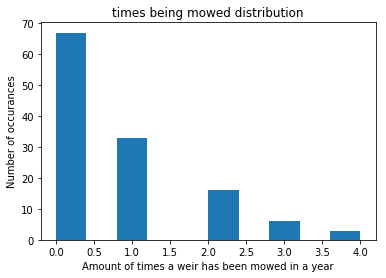

In [28]:

plt.hist(list(mowing_times_counts_yearly.values()))
plt.title('times being mowed distribution')
plt.ylabel('Number of occurances')
plt.xlabel('Amount of times a weir has been mowed in a year');


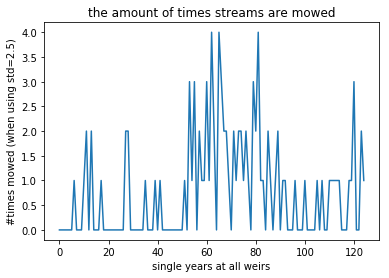

mowing count mode0    0
dtype: int64average is 0.76


In [29]:
df_mow_count = pd.DataFrame.from_dict(mowing_times_counts_yearly.items())#, columns=['weir', 'mowing_count'])
df_mow_count.set_axis(['weir', 'mow_count'], axis=1, inplace=True)

plt.plot(df_mow_count.index.values, df_mow_count['mow_count'])
plt.title('the amount of times streams are mowed')
plt.xlabel('single years at all weirs')
plt.ylabel('#times mowed (when using std=2.5)')
plt.show()

print('mowing count mode'+ str(df_mow_count['mow_count'].mode())+ 'average is ' + str(np.mean(df_mow_count['mow_count'])))

# Visualization and analysis mowing dates

In [21]:
def show_mowing_dates(data_path, weir, mowing_dates_dict):
    df = pd.read_csv(data_path + weir + '_feature_table.csv')
    mowing_dates = mowing_dates_dict[weir]
    
    
    
    for day in range(len(df)):
        if df['VERSCHIL'][day] <= 0:
            df['VERSCHIL'][day] = 0
    averages = []
    days = [i[:10] for i in df['TIME']]
    df['day'] = days
    for day in df['day'].unique():
        average = np.mean(df[df['day'] == day]['VERSCHIL'])
        averages.append(average)
    
    #print(df['day'][1])
    
    indexes = []
    for d in mowing_dates:
        dd = list(df['day'])
        idx = dd.index(d)
        indexes.append(idx)
    
    plt.plot(averages)
    plt.title('verschil graph with indication of found mowing dates')
    plt.xlabel('day from the start of datacollection')
    plt.ylabel('verschil')
    plt.vlines(indexes, alpha=0.3, ymin = -0.1, ymax= 0.7)


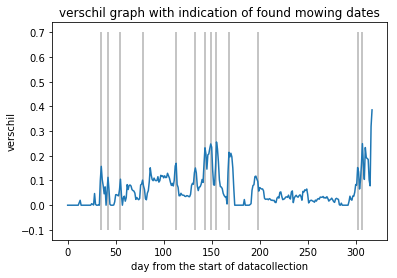

In [104]:
show_mowing_dates(path, '114CHS_114CKS', mowing_dates_dict2)

In [105]:
mowing_dates_dict2['114CHS_114CKS'] #This together with the figure above shows that there is an issue with consecutive days

['2020-10-07',
 '2020-10-14',
 '2020-10-27',
 '2020-11-19',
 '2020-12-24',
 '2021-01-13',
 '2021-01-23',
 '2021-01-29',
 '2021-02-04',
 '2021-02-17',
 '2021-03-19',
 '2021-07-01',
 '2021-07-06']

In [24]:
print(stats.mean(mowing_times_counts_yearly.values()))

NameError: name 'stats' is not defined

In [25]:
avg_counts = []
for weir in weirnames:
    weir = weir[:-18]
    years = GetYearsFromWeir(weir_names_and_years, weir)
    #print(years)
    total_times = 0
    for year in years:
        weir_year = str(weir) +'_'+ str(year)
        total_times += mowing_times_counts_yearly2[weir_year]
    average_times = total_times/len(years)
    print(str(weir) + ': ' + str(average_times))
    avg_counts.append(average_times)
        

103BIB_103BIC: 1.5
104B_104OYE: 3.25
104FCW_104FKW: 2.0
104FKW_104FVW: 3.0
104FVW_104B: 2.5
108GAR_108KAM: 4.0
108HOL_108GAR: 3.5
108HOO_108PAP: 3.5
108HUL_108WAN: 2.5
108IJZ_108HOL: 4.25
108LAA_108HUL: 2.5
108PAP_108LAA: 2.25
108WAN_108IJZ: 4.75
108XS_108HOO: 3.0
114CHS_114CKS: 4.5
114CZS_114DCS: 2.5
114DCS_114DES: 3.5
114DES_114DET: 10.0
211B_211A: 1.25
211C_211B: 3.25
211D_211C: 3.75
211E_211D: 4.75
211F_211E: 5.75
211G_211F: 4.5
211H_211G: 3.5
211I_211H: 4.75
211J_211I: 6.5
211K_211J: 3.25
211L_211K: 3.5
211M_211L: 3.25
211N_211M: 1.5
211VEL_211N: 1.75
248KA_248K: 2.5
251JE_248KA: 4.0
251JF_251JE: 0.5
251NC_251N: 2.5
251N_251JF: 5.0
251O_251NC: 0.5
251U_251T: 4.5


In [26]:
import statistics as stats
print(stats.mean(avg_counts),
stats.stdev(avg_counts))

3.4294871794871793 1.7157826949850778


In [ ]:
lowerbound = float(stats.mean(mowing_times_counts_yearly.values()) - stats.stdev(mowing_times_counts_yearly.values())*1.5)
upperbound = float(stats.mean(mowing_times_counts_yearly.values()) + stats.stdev(mowing_times_counts_yearly.values())*1.5)
print(lowerbound, upperbound)
values = list(mowing_times_counts_yearly.values())
keys = list(mowing_times_counts_yearly.keys())
for index in range(len(values)):
    if values[index] > upperbound or values[index] < lowerbound:
        print(keys[index], values[index])

In [ ]:
show_mowing_dates(path_yearly, '211M_211L_2020', mowing_dates_dict_yearly)

In [ ]:
untrustworthy_measurements_full_weir =['104B_104OYE', '104FVW_104B', '108PAP_108LAA', '114DES_114DET', '211B_211A', '211C_211B', '211E_211D', '211F_211E', '211K_211J', '211VEL_211N', '251JE_248KA']
untrustworthy_single_years = ['114CZS_114DCS_2020', '114DCS_114DES_2020', '211J_211I_2020', '211J_211I_2021']
not_sure = ['103BIB_103BIC_2020', '103BIB_103BIC_2021', '114CZS_114DCS_2021', '211J_211I_2018', '211I_211H', '211L_211K', '211M_211L', '248KA_248K']
incomplete['114CZS_114DCS_2020', '103BIB_103BIC_2020', '114DCS_114DES_2020', '114DES_114DET_2020', '248KA_248K_2020']
#look into start of 2020 in stream 211 (start can fluctuate since its around true winter?)

## Model evaluation results

In [6]:
results_df = pd.read_csv('C:/Users/20193723/Documents/Data Challenge 3/Data/mowing_model_acc_updated.csv')
results_df.head(10)

,Unnamed: 0,% peak dates close to mowing,% mowing dates with a predicted date close
0,103BIB_103BIC,0.500000,0.333333
1,104B_104OYE,0.255814,0.153846
2,104FCW_104FKW,0.473684,0.200000
3,104FKW_104FVW,0.736842,0.500000
4,104FVW_104B,0.217054,0.294118
5,108GAR_108KAM,0.387597,0.304348
6,108HOL_108GAR,0.156627,0.066667
7,108HOO_108PAP,0.325581,0.421053
8,108HUL_108WAN,0.465116,0.470588
9,108IJZ_108HOL,0.643411,0.473684


In [7]:
results_df.columns = ['stuwvak', 'close_to_mowing', 'date_close_to_prediction']

In [8]:
#% peak dates close to mowing
std_above_mean = results_df['close_to_mowing'].mean() + results_df['close_to_mowing'].std()*0.5
std_under_mean = results_df['close_to_mowing'].mean() - results_df['close_to_mowing'].std()*0.5
worst_close_to_mowing = results_df[results_df['close_to_mowing'] < std_under_mean]
best_close_to_mowing = results_df[results_df['close_to_mowing'] > std_above_mean]

In [9]:
sorted_by_close_to_mowing = results_df.sort_values('close_to_mowing')

In [10]:
sorted_by_close_to_mowing[:10]

,stuwvak,close_to_mowing,date_close_to_prediction
32,248KA_248K,0.000000,0.000000
34,251JF_251JE,0.000000,0.000000
18,211B_211A,0.000000,0.000000
17,114DES_114DET,0.000000,0.000000
33,251JE_248KA,0.000000,0.000000
27,211K_211J,0.046512,0.666667
20,211D_211C,0.069767,0.166667
30,211N_211M,0.101562,0.166667
37,251O_251NC,0.131579,0.333333
13,108XS_108HOO,0.152941,0.076923


In [11]:
sorted_by_close_to_mowing[(sorted_by_close_to_mowing['close_to_mowing'] == 0.000000) | (sorted_by_close_to_mowing['close_to_mowing'] == 1.000000)]

,stuwvak,close_to_mowing,date_close_to_prediction
32,248KA_248K,0.0,0.0
34,251JF_251JE,0.0,0.0
18,211B_211A,0.0,0.0
17,114DES_114DET,0.0,0.0
33,251JE_248KA,0.0,0.0


In [12]:
sorted_by_close_to_mowing[-10:]

,stuwvak,close_to_mowing,date_close_to_prediction
36,251N_251JF,0.605263,0.250000
38,251U_251T,0.605263,0.200000
12,108WAN_108IJZ,0.620155,0.571429
9,108IJZ_108HOL,0.643411,0.473684
11,108PAP_108LAA,0.705426,0.625000
3,104FKW_104FVW,0.736842,0.500000
16,114DCS_114DES,0.750000,0.300000
14,114CHS_114CKS,0.750000,0.153846
15,114CZS_114DCS,0.785714,0.500000
22,211F_211E,0.806202,0.484848


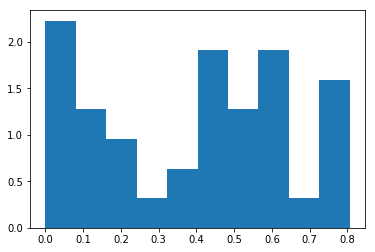

In [18]:
plt.hist(results_df['close_to_mowing'], bins= 10, density= True);

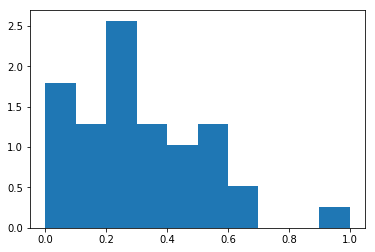

In [19]:
plt.hist(results_df['date_close_to_prediction'], bins= 10, density= True);

In [76]:
sorted_by_close_to_prediction = results_df.sort_values('date_close_to_prediction')

In [77]:
sorted_by_close_to_prediction[:10]

,stuwvak,close_to_mowing,date_close_to_prediction
33,251JE_248KA,1.000000,0.000000
32,248KA_248K,1.000000,0.000000
18,211B_211A,0.000000,0.000000
17,114DES_114DET,0.000000,0.000000
13,108XS_108HOO,0.541176,0.076923
14,114CHS_114CKS,1.000000,0.153846
38,251U_251T,0.947368,0.200000
2,104FCW_104FKW,1.000000,0.200000
35,251NC_251N,0.684211,0.250000
31,211VEL_211N,0.519380,0.250000


In [83]:
sorted_by_close_to_prediction[sorted_by_close_to_prediction['date_close_to_prediction'] < 0.4]

,stuwvak,close_to_mowing,date_close_to_prediction
33,251JE_248KA,1.000000,0.000000
32,248KA_248K,1.000000,0.000000
18,211B_211A,0.000000,0.000000
17,114DES_114DET,0.000000,0.000000
13,108XS_108HOO,0.541176,0.076923
14,114CHS_114CKS,1.000000,0.153846
38,251U_251T,0.947368,0.200000
2,104FCW_104FKW,1.000000,0.200000
35,251NC_251N,0.684211,0.250000
31,211VEL_211N,0.519380,0.250000


In [78]:
sorted_by_close_to_prediction[-10:]

,stuwvak,close_to_mowing,date_close_to_prediction
27,211K_211J,0.240310,0.666667
5,108GAR_108KAM,0.418605,0.695652
6,108HOL_108GAR,0.301205,0.733333
8,108HUL_108WAN,0.829457,0.764706
7,108HOO_108PAP,0.519380,0.789474
11,108PAP_108LAA,0.813953,0.812500
20,211D_211C,0.829457,0.833333
24,211H_211G,0.751938,0.916667
34,251JF_251JE,0.000000,1.000000
19,211C_211B,0.503876,1.000000
